<a href="https://colab.research.google.com/github/Zeos-ctrl/MicroprojectPXT992/blob/main/GWBModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read numpy array
data = np.load('/content/drive/MyDrive/csg_strain_data.npy')
params = np.load('/content/drive/MyDrive/csg_param_data.npy')
print(data.shape)
print(params.shape)

(3000, 3, 1024)
(3000, 5)


0.2826382285968293
382.29511064820565
56.0
0.029296875
116.0


<Figure size 1200x600 with 0 Axes>

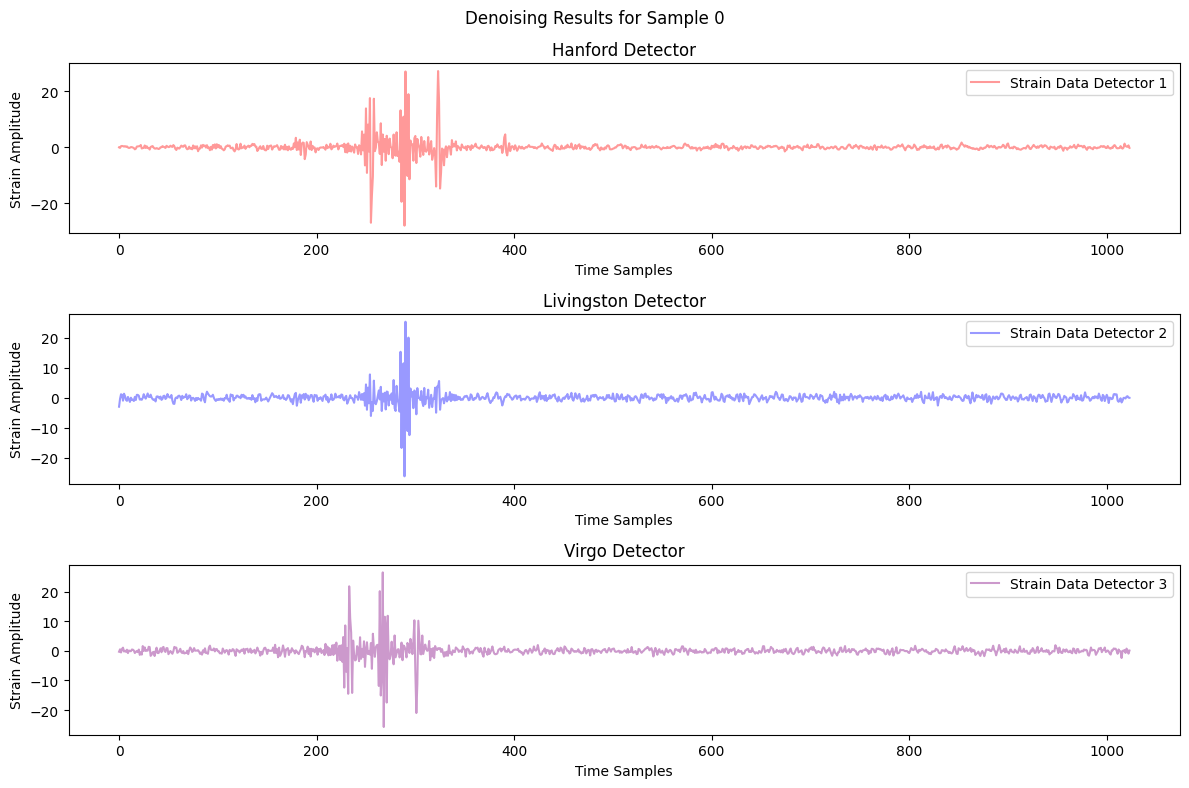

In [ ]:
time = np.linspace(0, 1024, 1024)

sample_idx = 0
plt.figure(figsize=(12, 6))
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
detectors = ['Hanford', 'Livingston', 'Virgo']
col = ["red", "blue", "purple"]
for d in range(3):
    axs[d].plot(data[sample_idx][d], color = f"{col[d]}", label=f'Strain Data Detector {d+1}', alpha=0.4)
    axs[d].legend()
    axs[d].set_title(f'{detectors[d]} Detector')
    axs[d].set_xlabel("Time Samples")
    axs[d].set_ylabel("Strain Amplitude")

print(params[sample_idx][0])
print(params[sample_idx][1])
print(params[sample_idx][2])
print(params[sample_idx][3])
print(params[sample_idx][4])
plt.suptitle(f"Denoising Results for Sample {sample_idx}")
plt.tight_layout()
plt.show()

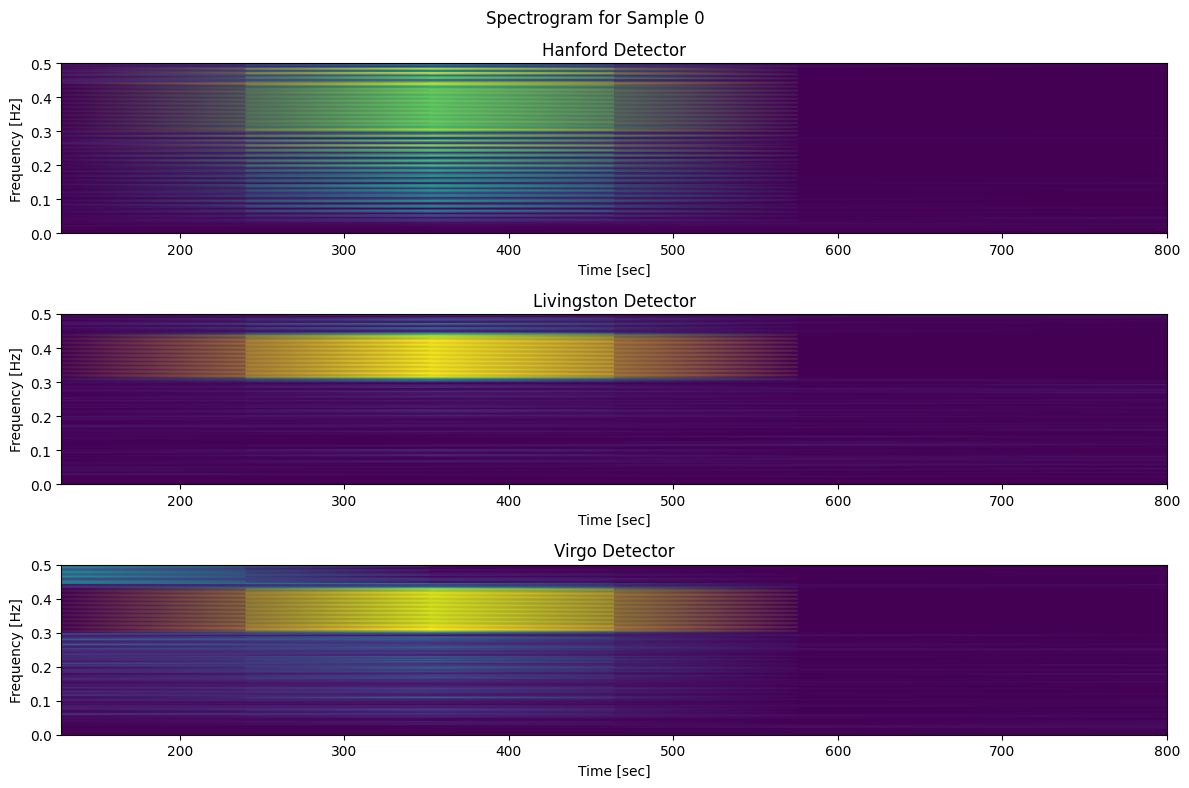

In [ ]:
# Convert waveform to time frequency domain
from scipy.signal import spectrogram

fig, axs = plt.subplots(3, 1, figsize=(12, 8))
for d in range(3):
    f, t, Sxx = spectrogram(data[sample_idx][d])
    axs[d].pcolormesh(t, f, Sxx, shading='gouraud')
    axs[d].set_ylabel('Frequency [Hz]')
    axs[d].set_xlabel('Time [sec]')
    axs[d].set_title(f'{detectors[d]} Detector')

plt.suptitle(f'Spectrogram for Sample {sample_idx}')
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Transpose X to match Keras Conv1D expected input shape: (samples, time steps, channels)
X = np.transpose(data, (0, 2, 1))

# Split data (70-20-10 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, params, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

# Define the model using the Functional API
inputs = keras.Input(shape=(1024, 3))
x = layers.Conv1D(36, kernel_size=1, activation='relu')(inputs)

# ResNet Block 1
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 2
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 3
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# Class Activation Map (CAM) preserving the temporal dimension.
cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
x_weighted = layers.Multiply()([x, cam_output])

# Feed the CAM-weighted sequence into the transformer block
# Project features to a desired model dimension
x_transformer_input = layers.Dense(256, activation='relu')(x_weighted)

x_transformer = layers.LayerNormalization()(x_transformer_input)
x_transformer = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x_transformer, x_transformer)
x_transformer = layers.LayerNormalization()(x_transformer)
x_transformer = layers.Dense(256, activation='relu')(x_transformer)

# Collapse the time dimension after the transformer has focused on the important regions
x_pooled = layers.GlobalAveragePooling1D()(x_transformer)

# Fully Connected Layers for regression
x_fc = layers.Dense(256, activation='relu')(x_pooled)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(128, activation='relu')(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)

outputs = layers.Dense(5, activation='linear')(x_fc)

model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'R2Score'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping_cb, checkpoint_cb])

test_loss, test_mae, test_r2score = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2score:.4f}")

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - R2Score: -33844.8398 - loss: 10401.8223 - mae: 61.0689 - val_R2Score: -2.5977 - val_loss: 3144.0552 - val_mae: 31.4379
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - R2Score: -25720.0645 - loss: 3073.5686 - mae: 36.4464 - val_R2Score: -143.7261 - val_loss: 2187.3391 - val_mae: 26.8514
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - R2Score: -8862.3096 - loss: 2547.5903 - mae: 31.8578 - val_R2Score: -102.7144 - val_loss: 1906.3761 - val_mae: 24.9390
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - R2Score: -3755.2632 - loss: 2080.2913 - mae: 27.7637 - val_R2Score: -11.0410 - val_loss: 1380.7239 - val_mae: 20.0747
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - R2Score: -2109.5493 - loss: 2123.6731 - mae: 26.8060 - val_R2Score: -17.3659 - val_loss: 1190.4769 - val_mae: 19.2306
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - R2Score: -652.7616 - loss: 1736.0974 - mae: 23.9271 - val_R2Score: -6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


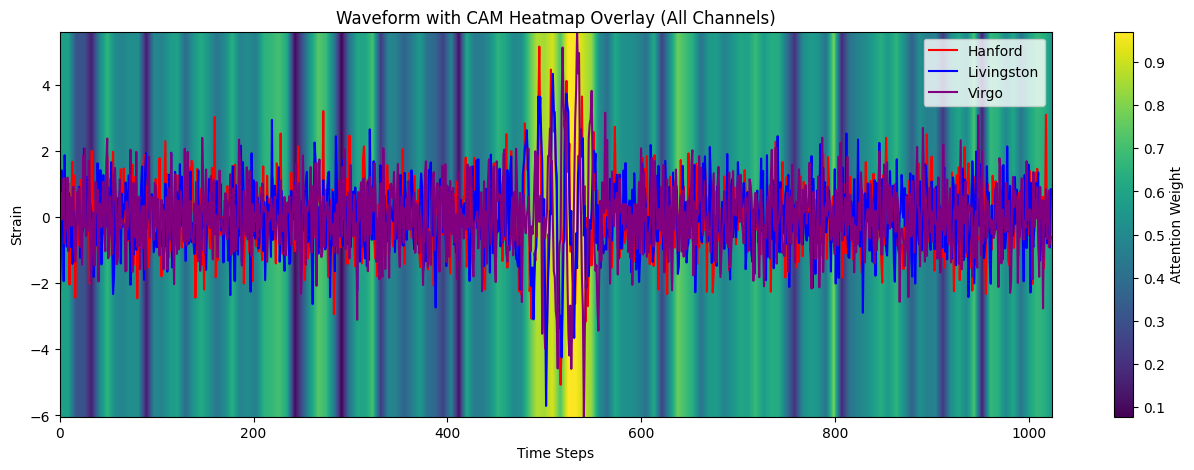

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


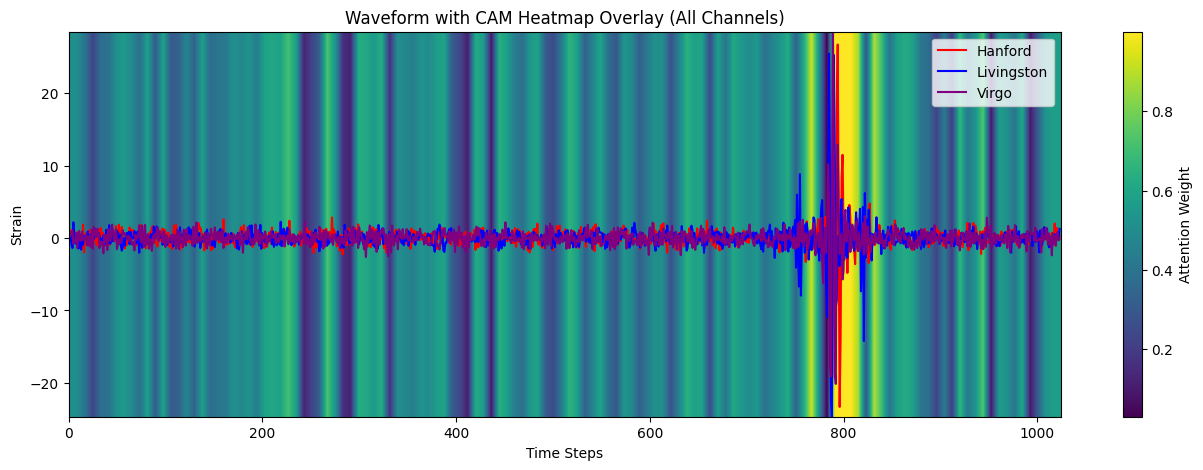

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


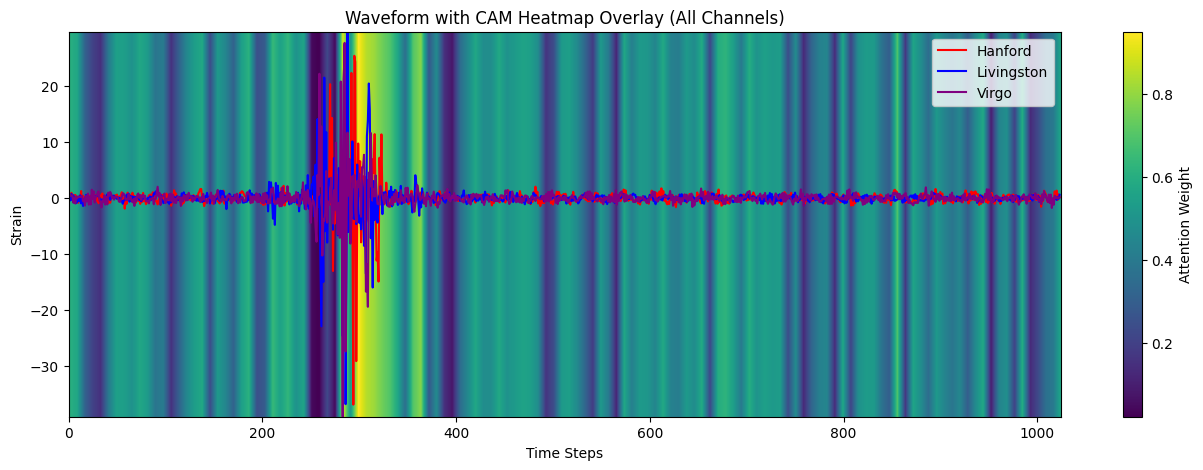

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


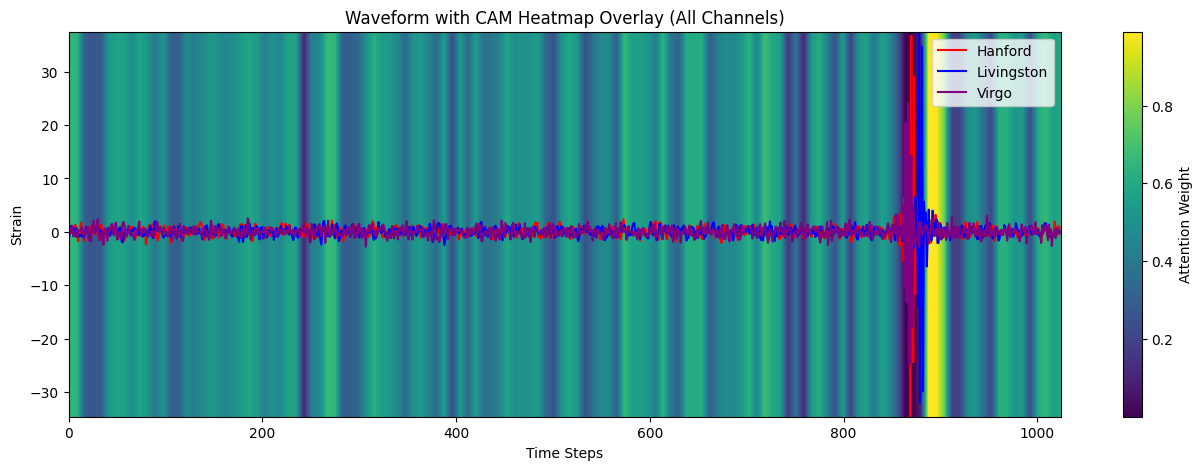

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


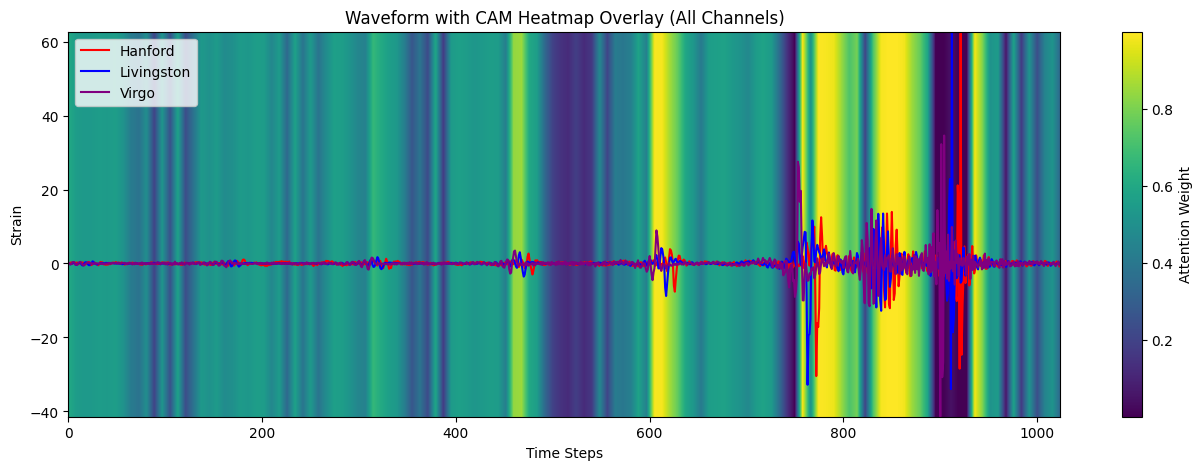

In [ ]:
def visualize_cam_all_channels(sample_index):
    # Extract the waveform sample
    waveform_sample = X_test[sample_index]

    # Determine overall min and max for y-axis across all channels
    y_min = waveform_sample.min()
    y_max = waveform_sample.max()

    # Build a model that outputs the CAM
    cam_model = keras.Model(inputs=model.input, outputs=model.get_layer('cam_layer').output)

    # Get the CAM output for the sample
    cam_out = cam_model.predict(X_test[[sample_index]])[0]
    cam_out = cam_out.squeeze()

    # Upsample the CAM to match the waveform length
    num_points = 1024
    x_old = np.linspace(0, num_points - 1, num=len(cam_out))
    x_new = np.arange(num_points)
    cam_upsampled = np.interp(x_new, x_old, cam_out)

    # Create a 2D heatmap array by replicating the upsampled CAM
    heatmap = np.tile(cam_upsampled, (10, 1))

    # Lets see what we have
    fig, ax = plt.subplots(figsize=(16, 5))
    x = np.arange(num_points)

    # Plot each channel with a different color
    ax.plot(x, waveform_sample[:, 0], label='Hanford', color='red')
    ax.plot(x, waveform_sample[:, 1], label='Livingston', color='blue')
    ax.plot(x, waveform_sample[:, 2], label='Virgo', color='purple')

    # Overlay the heatmap using imshow
    im = ax.imshow(heatmap, aspect='auto', cmap='viridis', alpha=1,
                   extent=[0, num_points, y_min, y_max],
                   origin='lower')

    # Add a colorbar with a label
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight')

    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Strain')
    ax.set_title('Waveform with CAM Heatmap Overlay (All Channels)')
    ax.legend()
    plt.show()

# Think of 5 numbers between 0-300
indexes = np.random.randint(0, 300, 5)
for i in indexes:
    visualize_cam_all_channels(sample_index=i)

In [ ]:
X_resnet = np.transpose(data, (0, 2, 1))  # shape: (3000, 1024, 3)
X_resnet = np.expand_dims(X_resnet, axis=2)  # shape: (3000, 1024, 1, 3)
X_resnet = np.tile(X_resnet, (1, 1, 32, 1))  # Now shape: (3000, 1024, 32, 3), satisfies min size (32x32)

resnet_train, resnet_temp, resnet_y_train, resnet_y_temp = train_test_split(X_resnet, params, test_size=0.2, random_state=42)
resnet_val, resnet_test, resnet_y_val, resnet_y_test = train_test_split(resnet_temp, resnet_y_temp, test_size=1/3, random_state=42)

base_model = keras.applications.ResNet50(
    include_top=False,
    weights=None,  # Train from scratch
    input_shape=(1024, 32, 3),
    pooling='avg'
)

x = base_model.output

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='linear')(x)
resnet_model = keras.Model(inputs=base_model.input, outputs=outputs)

resnet_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'R2Score'])
resnet_history = resnet_model.fit(resnet_train, resnet_y_train, validation_data=(resnet_val, resnet_y_val), epochs=100, batch_size=16, callbacks=[early_stopping_cb, checkpoint_cb])

resnet_test_loss, resnet_test_mae, resnet_test_r2score = resnet_model.evaluate(resnet_test, resnet_y_test)
print(f"ResNet50 Test MAE: {resnet_test_mae:.4f}")
print(f"ResNet50 Test R2 Score: {resnet_test_r2score:.4f}")

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 145ms/step - R2Score: -28946.2520 - loss: 6559.7700 - mae: 48.1313 - val_R2Score: -194932.5781 - val_loss: 1581725.6250 - val_mae: 727.7149
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 114ms/step - R2Score: -10478.8711 - loss: 2771.5767 - mae: 33.2722 - val_R2Score: -207.4437 - val_loss: 23198.4531 - val_mae: 78.3292
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - R2Score: -3674.1113 - loss: 2290.5645 - mae: 28.8355 - val_R2Score: -80.8434 - val_loss: 55401.5742 - val_mae: 123.7862
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - R2Score: -1292.2235 - loss: 2030.7620 - mae: 26.0686 - val_R2Score: -423.0081 - val_loss: 4836.6836 - val_mae: 36.8410
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - R2Score: -665.1943 - loss: 1803.4008 - mae: 23.6442 - val_R2Score: -47.6346 - val_loss: 14181.1826 - val_mae: 54.9975
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - R2Score: -179.0328 - loss: 1645.0568 - mae: 22.

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


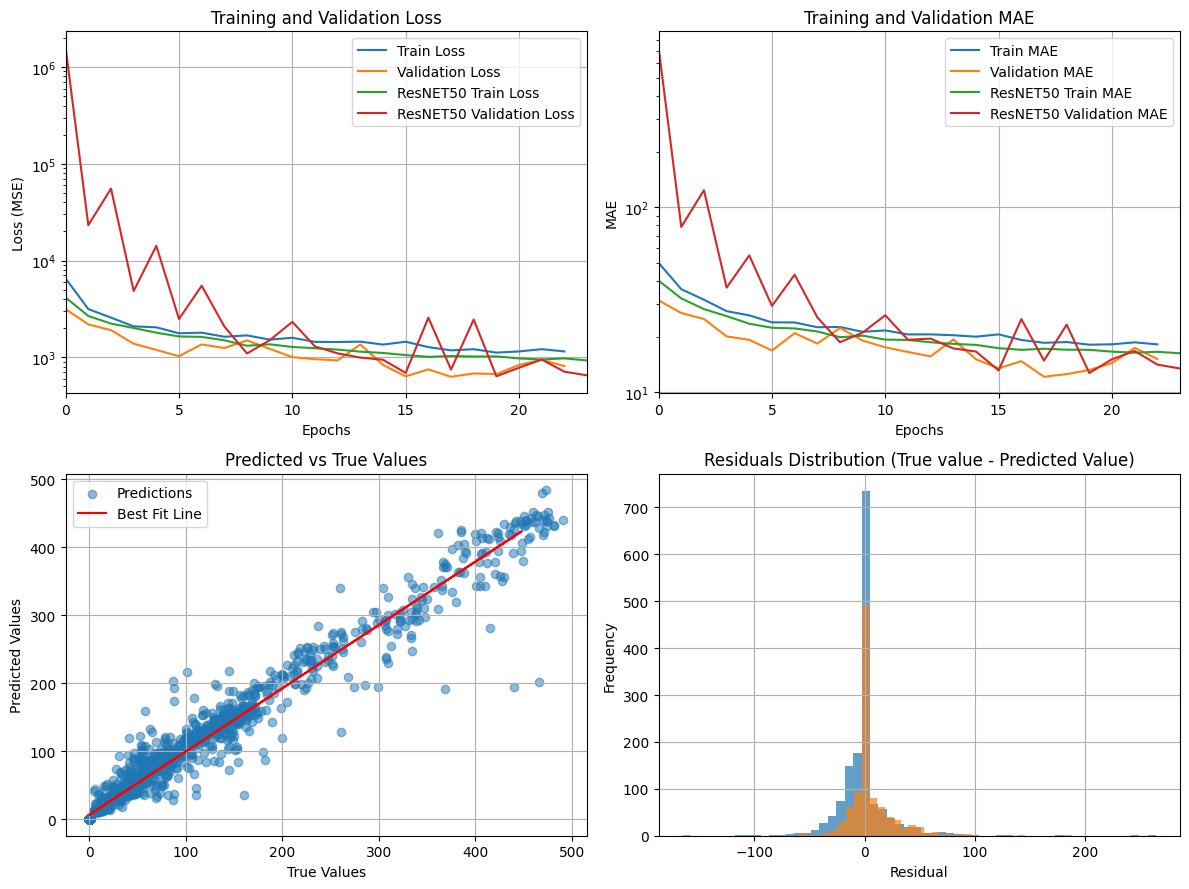

In [ ]:
# Generate model predictions
y_pred = model.predict(X_test)
resnet_y_pred = resnet_model.predict(resnet_test)

# Calculate residuals
residuals = y_test - y_pred
resnet_residuals = resnet_y_test - resnet_y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Loss Curve (Training vs Validation)
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].plot(resnet_history.history['loss'], label='ResNET50 Train Loss')
axes[0, 0].plot(resnet_history.history['val_loss'], label='ResNET50 Validation Loss')
axes[0, 0].set_xlim([0, len(history.history['loss'])])
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Mean Absolute Error Regression Statistic
axes[0, 1].plot(history.history['mae'], label='Train MAE')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
axes[0, 1].plot(resnet_history.history['mae'], label='ResNET50 Train MAE')
axes[0, 1].plot(resnet_history.history['val_mae'], label='ResNET50 Validation MAE')
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim([0, len(history.history['mae'])])
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Training and Validation MAE')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Prediction vs True Values Scatter Plot with Line of Best Fit
axes[1, 0].scatter(y_test, y_pred, alpha=0.5, label="Predictions")
m, b = np.polyfit(y_test.flatten(), y_pred.flatten(), 1)
axes[1, 0].plot(y_test[4], m * y_test[4] + b, color="red", label="Best Fit Line")
axes[1, 0].set_xlabel("True Values")
axes[1, 0].set_ylabel("Predicted Values")
axes[1, 0].set_title("Predicted vs True Values")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Residuals Histogram
axes[1, 1].hist(residuals.flatten(), bins=50, alpha=0.7, label="Model Residuals")
axes[1, 1].hist(resnet_residuals.flatten(), bins=50, alpha=0.7, label="ResNET50 Residuals")
axes[1, 1].set_xlabel("Residual")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Residuals Distribution (True value - Predicted Value)")
axes[1, 1].grid(True)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()